# Test the effectiveness of different distance functions in tSNE. The goal is to put state-word relation to the highest priority

In [1]:
import torch 
import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas import DataFrame

from collections import Counter
from tqdm import tqdm 
from data_utils import News20Data
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords
from matplotlib.pyplot import figure
from matplotlib import collections as mc
from matplotlib.colors import ListedColormap

## Pipeline

In [2]:
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['"', "'", '.', ',', '?', '!', '-', '[CLS]', '[SEP]', '[PAD]',
  ':', '@', '/', '[', ']', '(', ')', 'would', 'like'])
STOPWORDS = set(STOPWORDS)
batch_size=20
dataset = News20Data(batch_size=batch_size)

Processing dataset ...
Reading data ...
... 0 seconds
Tokenizing and sorting train data ...
... 113 seconds
Tokenizing and sorting dev data ...
... 37 seconds
Tokenizing and sorting test data ...
... 38 seconds


In [7]:
bert = BertModel.from_pretrained('bert-base-uncased')
bert.to('cuda')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

ckpt_path = '../models/bertnet_0.0.4.10.4/ckpt-e16.ptmodel.pt'
ckpt = torch.load(ckpt_path)
state_matrix = ckpt['state_matrix']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def read_state_freq(path):
    state_freq = np.zeros(2000)
    state_nonstop_freq = np.zeros(2000)
    with open(path) as fd:
        lines = fd.readlines()
        for li, l in enumerate(lines):
            if(li % 3 == 0):
                l = l.split()
                state_id = int(l[1])
                state_freq[state_id] = int(l[3])
                state_nonstop_freq[state_id] = int(l[5])
                
    state_freq_norm = np.log(state_freq)
    state_freq_norm = state_freq_norm - state_freq_norm.min()
    state_freq_norm = state_freq_norm / state_freq_norm.max()
    
    state_nonstop_freq_r = state_nonstop_freq / state_freq
    state_freq_idx_sort = state_freq.argsort()[::-1]
    state_freq_idx_inverse = {}
    for i, j in enumerate(state_freq_idx_sort):
        state_freq_idx_inverse[j] = i
    state_stop_freq = state_freq - state_nonstop_freq
    return state_freq_norm, state_nonstop_freq_r, state_freq_idx_sort, state_freq_idx_inverse, state_freq, state_nonstop_freq

In [9]:
state_freq_norm, state_nonstop_freq_r, state_freq_idx_sort, state_freq_idx_inverse, state_freq, state_nonstop_freq = read_state_freq(
    '/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_s2w.txt')

In [10]:
word_state_freq = {}
with open('/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_s2w.txt') as fd:
    for l in fd:
        if l.startswith('state'):
            current_state = l.split()[1]
        else:
            words = l[:-4].split(' | ')
            for w in words:
                w = w.split(' ')[0]
                if(w in word_state_freq): 
                    if(current_state not in word_state_freq[w]): word_state_freq[w].append(current_state)
                else: word_state_freq[w] = [current_state]

words_ = []
freq_ = []
for w in word_state_freq: 
    words_.append(w)
    freq_.append(len(word_state_freq[w]))
freq_ = np.log(np.array(freq_))
freq_ = freq_ - freq_.min() + 0.1
freq_ /= freq_.max()

word_state_freq_norm = {w: f for w, f in zip(words_, freq_)}

In [108]:
def read_word_state_dist(fpath):
    word2state = dict()
    with open(fpath) as fd:
        lines = fd.readlines()
        for l in lines:
            if(l.startswith('word')):
                l_ = l.split()
                word = l_[1]
                freq = int(l_[3])
                if(freq > 0):
                    word2state[word] = {}
                    word2state[word]['freq'] = freq
            elif(l.startswith('s')):
                for sc in l[:-4].split(' | '):
                    sc = sc.split()
                    if(int(sc[1][1:]) > 0): word2state[word][int(sc[0][1:])] = int(sc[1][1:])
    return word2state

In [109]:
word2state = read_word_state_dist('/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_w2s.txt')

In [110]:
word_freq = np.array([word2state[w]['freq'] for w in word2state])
word_num_state = np.array([len(word2state[w]) for w in word2state])
word_num_state = np.log(word_num_state) + 0.1
word_num_state_norm = word_num_state / word_num_state.max()

In [11]:
train_loader = dataset.train_dataloader()

all_tokens = []
for bi, batch in tqdm(enumerate(train_loader)):
    for bi_id in batch['input_ids']:
        t = tokenizer.convert_ids_to_tokens(bi_id)
        all_tokens.extend(t)
word_freq = Counter(all_tokens)

words_ = []
word_freq_norm = []
for wi, wf in word_freq.most_common():
    if(wi not in ['[CLS]', '[SEP]', '[PAD]']):
        words_.append(wi)
        word_freq_norm.append(np.log(wf))
word_freq_norm = np.array(word_freq_norm)
word_freq_norm -= word_freq_norm.min()
word_freq_norm += 0.1
word_freq_norm /= word_freq_norm.max()

word_freq_norm = {wi: wf for wi, wf in zip(words_, word_freq_norm)}

7836it [00:24, 314.36it/s]


In [12]:
dev_loader = dataset.val_dataloader()

embeddings = []
tokens = []
# TODO: implement indexing
id2word = {}
word2idx = {}
wordid2sentid = {}
with torch.no_grad():
    for bi, batch in tqdm(enumerate(dev_loader)):
        if(bi == 1000): break
        emb = bert(batch['input_ids'].to('cuda'), batch['attention_mask'].to('cuda'))[0]
        for bij, bi_id in enumerate(batch['input_ids']):
            t = tokenizer.convert_ids_to_tokens(bi_id)
            tokens_len = len(tokens)
            for word_id, tij in enumerate(t):
                word_id = tokens_len + word_id
                id2word[word_id] = tij
                if(tij in word2idx): word2idx[tij].append(word_id)
                else: word2idx[tij] = [word_id]
                wordid2sentid[word_id] = bi * batch_size + bij
            tokens.extend(t)
        embeddings.append(emb.view(-1, 768))
    embeddings = torch.cat(embeddings, 0).view(-1, 768)

1000it [00:25, 39.12it/s]


In [13]:
emb_non_stop = []
emb_non_stop_ids = []
emb_stop = []
emb_stop_ids = []
for wi, w in tqdm(enumerate(embeddings)):
    if(id2word[wi] in STOPWORDS):
        emb_stop.append(w)
        emb_stop_ids.append(wi)
    else:
        emb_non_stop.append(w)
        emb_non_stop_ids.append(wi)
emb_non_stop = torch.stack(emb_non_stop, 0)
emb_stop = torch.stack(emb_stop, 0)

word_id_non_stop_to_origin = emb_non_stop_ids
word_id_origin_to_non_stop = {origin_id: non_stop_id for non_stop_id, origin_id in enumerate(emb_non_stop_ids)}

print(emb_stop.size())
print(emb_non_stop.size())

195260it [00:00, 696928.76it/s]


torch.Size([122562, 768])
torch.Size([72698, 768])


In [14]:
with torch.no_grad():
    sim_word_state = torch.matmul(embeddings, state_matrix.transpose(0, 1))

In [15]:
def query_sim_words(state_id, sim_word_state, id2word, wordid2sentid, thres=3, k=2000):
    """Query similar words of a given state"""
    K = 50000
    torch.cuda.empty_cache()
    
    sim_words = []
    sim_words_in_sents = []
    _, sim_word_idx = sim_word_state[:, state_id].topk(K)
    for wi in sim_word_idx:
        wi = wi.item()
        w = id2word[wi]
        if(w in STOPWORDS): continue
        sim_words.append(w)
        sim_words_in_sents.append(wordid2sentid[wi])
        if(len(sim_words) == k): break
    sim_words_set = Counter(sim_words)
    sim_words_set_ = dict()
    for w, c in sim_words_set.most_common():
        if(c > thres):
            sim_words_set_[w] = c
    return sim_word_idx.cpu().numpy(), sim_words, sim_words_set_, sim_words_in_sents

In [16]:
sim_word_idx, sim_words, sim_words_set, sim_words_in_sents = query_sim_words(476, sim_word_state, id2word, wordid2sentid, k=1000)
print(sim_words_set)

{'##ed': 24, 'organization': 15, 'made': 14, 'developed': 12, '##ted': 10, 'based': 9, 'said': 9, 'raised': 8, 'brought': 7, 'supported': 7, 'started': 7, '##d': 7, 'failed': 7, 'created': 6, 'held': 6, 'associated': 6, 'took': 6, 'deleted': 6, 'installed': 5, 'went': 5, 'set': 5, 'built': 5, 'left': 5, 'elected': 5, 'saw': 5, 'fixed': 5, 'funded': 4, 'designed': 4, 'involved': 4, 'led': 4, 'produced': 4, 'accepted': 4, 'available': 4, 'caught': 4, 'stated': 4, 'surrounded': 4, 'used': 4, 'determined': 4, 'defined': 4, 'located': 4, 'proven': 4, 'chosen': 4, 'killed': 4, 'reduced': 4, 'handled': 4, 'explained': 4, 'protected': 4, 'packed': 4, 'issued': 4, 'didn': 4, 'came': 4, 'related': 4, 'passed': 4}


## Factory Functions - tSNE

In [17]:
def tsne_preprocess(state_matrix, word_matrix, topk, state_freq_idx_sort, sample_size):
    state_matrix = state_matrix.cpu().numpy()[state_freq_idx_sort][:topk]
    
    word_matrix = word_matrix.cpu().numpy()
    sample_idx = np.random.choice(len(word_matrix), sample_size, replace=False)
    word_matrix = word_matrix[sample_idx]
    
    n_state = state_matrix.shape[0]
    emb_matrix = np.concatenate([state_matrix, word_matrix], 0)
    
    n_state = np.zeros((emb_matrix.shape[0], 1)) + n_state
    inx = np.reshape(np.arange(emb_matrix.shape[0]), [emb_matrix.shape[0], 1])
    emb_matrix = np.concatenate([n_state, inx, emb_matrix], 1)
    return emb_matrix, sample_idx

def metric_fn_0(x1, x2):
    """Hard set metrics between states to be large"""
    n_state = x1[0]
    x1_id = x1[1]
    x2_id = x2[1]
    if(x1_id < n_state and x2_id < n_state): 
        m = 100
    else:
        m = np.exp(-(x1[2:] * x2[2:]).sum())
    return m

def metric_fn_1(x1, x2):
    """Hard set metrics between states to be large, set state-word metrics to be close"""
    n_state = x1[0]
    x1_id = x1[1]
    x2_id = x2[1]
    if(x1_id < n_state and x2_id < n_state): 
        m = 10000
    elif(x1_id < n_state or x2_id < n_state):
        m = np.exp(-(x1[2:] * x2[2:]).sum())
    else:
        m = 100 * np.exp(-(x1[2:] * x2[2:]).sum())
    return m

def tsne_transform_dot_prod_no_state(emb_matrix, perplexity, n_iter, topk, metric_fn):
    """Do tsne"""
    tsne = TSNE(n_components=2, verbose=2, perplexity=perplexity, n_iter=n_iter, metric=metric_fn)
    emb_transform = tsne.fit_transform(emb_matrix)
    
    emb_background = emb_transform[topk:]
    state_matrix_transform = emb_transform[: topk]
    return emb_background, state_matrix_transform

## Factory functions - query

In [18]:
def get_word_sample_freq(sample_idx, word_freq_norm, id2word, emb_non_stop_ids):
    """Get the number of frequency of the sampled words"""
    word_sample_freq = []
    impute_cnt_ = 0
    for si in tqdm(sample_idx):
        si_word = id2word[emb_non_stop_ids[si]]
        if(si_word in word_freq_norm):
            word_sample_freq.append(word_freq_norm[si_word])
        else:
            word_sample_freq.append(0.5)
            impute_cnt_ += 1
    print(impute_cnt_)
    return np.array(word_sample_freq)

def query_sim_words(state_id, sim_word_state, id2word, wordid2sentid, thres=3, k=2000):
    """Query similar words of a given state"""
    K = 50000
    torch.cuda.empty_cache()
    
    sim_words = []
    sim_words_in_sents = []
    _, sim_word_idx = sim_word_state[:, state_id].topk(K)
    for wi in sim_word_idx:
        wi = wi.item()
        w = id2word[wi]
        if(w in STOPWORDS): continue
        sim_words.append(w)
        sim_words_in_sents.append(wordid2sentid[wi])
        if(len(sim_words) == k): break
    sim_words_set = Counter(sim_words)
    sim_words_set_ = dict()
    for w, c in sim_words_set.most_common():
        if(c > thres):
            sim_words_set_[w] = c
    return sim_word_idx.cpu().numpy(), sim_words, sim_words_set_, sim_words_in_sents

def build_word_list(word, word2idx, word_id_origin_to_non_stop, word_id_non_stop_to_sampled):
    """Query all instances of a given word"""
    word_list = [word_id_origin_to_non_stop[wi] for wi in word2idx[word]]
    word_list_ = []
    for wi in word_list:
        if(wi in word_id_non_stop_to_sampled): 
            word_list_.append(word_id_non_stop_to_sampled[wi])
    return word_list_

def build_state_word_list(query_states, state_id_origin_to_topk, sim_word_state, id2word, wordid2sentid, word_id_origin_to_non_stop, word_id_non_stop_to_sampled, n_words=20):
    """Given a list of states, build their corresponding words list"""
    state_word_list = []
    for si in query_states:
        sim_word_idx, sim_words, sim_words_set, sim_words_in_sents = query_sim_words(si, sim_word_state, id2word, wordid2sentid, thres=3, k=2000)
        sim_word_idx_ = []
        for wi in sim_word_idx:
            if(id2word[wi] in STOPWORDS): continue
            else: sim_word_idx_.append(wi)
        word_str = [id2word[wi] for wi in sim_word_idx_[:n_words]]
        sim_word_idx_ = [word_id_origin_to_non_stop[idx] for idx in sim_word_idx_]
        sim_word_idx_ = [word_id_non_stop_to_sampled[idx] for idx in sim_word_idx_ if idx in word_id_non_stop_to_sampled][:n_words]
        
        si_ = state_id_origin_to_topk[si]
        state_word_list.append([si_, sim_word_idx_, word_str, si])
    return state_word_list

def build_state_word_list_transformed(s_idx, state_emb, word_emb, state_id_origin_to_topk, word_id_sampled_to_non_stop, word_id_non_stop_to_origin, id2word, n_words=20):
    """Given a list of states, build their corresponding words list, performed in the transformed space"""
    state_word_list = []
    for si in s_idx:
        si = state_id_origin_to_topk[si]
        sim_words_idx = np.sum((word_emb - state_emb[si]) ** 2, -1).argsort()
        word_idx = []
        word_str = []
        for wi in sim_words_idx[:n_words]:
            word_idx.append(wi)
            wi_ = word_id_sampled_to_non_stop[wi]
            wi_ = word_id_non_stop_to_origin[wi_]
            word = id2word[wi_]
            word_str.append(word)
        state_word_list.append([si, word_idx, word_str])
    return state_word_list

def query_sim_word(word_idx, word_emb_sampled, word_id_sampled_to_non_stop, word_id_non_stop_to_origin):
    """Query similar words of a given state
    """
    sim_words_idx = np.sum(word_emb_sampled[:, 2:] * word_emb_sampled[word_idx][2:], 1).argsort()[::-1]
    sim_words_idx = [word_id_non_stop_to_origin[word_id_sampled_to_non_stop[wi]] for wi in sim_words_idx]
    return sim_words_idx

def query_sim_word_transformed(word_idx, word_emb_transformed, word_id_non_stop_to_origin, word_id_sampled_to_non_stop):
    """Query in the transformed space
    """
    sim_words_idx = np.sum((word_emb_transformed - word_emb_transformed[word_idx])**2, 1).argsort()
    sim_words_idx = [word_id_non_stop_to_origin[word_id_sampled_to_non_stop[si]] for si in sim_words_idx]
    return sim_words_idx

## Factory functions - visualization

In [115]:
def plot_state_word_w_query(emb_background, 
                            state_matrix, 
                            state_nonstop_freq_r, 
                            state_freq_norm, 
                            word_sample_freq=None, 
                            word_only=False, 
                            state_size_base=1, 
                            word_size_base=1,
                            filter_static=False, 
                            filter_contextualized=False,
                            state_word_list=None,
                            high_light_query=False,
                            word_list=None,
                            query_states_scale=3,
                            filter_query_dist=20,
                            left_colorbar=False,
                            right_colorbar=False
                            ):
    sns.set(rc={'figure.figsize':(8,6), 'figure.dpi': 200})
    
    fig, axs = plt.subplots(1, 1, constrained_layout=True) 

    ## plot words
    if(word_sample_freq is None):
        axs.scatter(x=emb_background[:, 0], y=emb_background[:, 1], s=word_size_base, color='darkcyan', linewidths=0, marker='D')
    else: 
        if(not high_light_query):
            pcm = axs.scatter(x=emb_background[:, 0], y=emb_background[:, 1], s=word_size_base,c=word_sample_freq,
                        cmap='coolwarm', linewidths=0, marker='D')
            if(left_colorbar):
                cbar = fig.colorbar(pcm, ax=axs, location='left', ticks=[0.2, 0.6], shrink=0.8)
#                 cbar = fig.colorbar(pcm, ax=axs, location='left', shrink=0.8)
                cbar.ax.set_yticklabels(['Less states', 'More states'], fontsize=15, rotation=270, verticalalignment='center') 
        else:
            axs.scatter(x=emb_background[:, 0], y=emb_background[:, 1], s=word_size_base,c=word_sample_freq,
                        cmap='coolwarm', linewidths=0, marker='D', alpha=0.1)
    if(word_list is None): 
        fig_words = plt.scatter(x=emb_background[0, 0], y=emb_background[0, 1], s=word_size_base+10, color='tab:blue', linewidths=0, marker='D')
    
    ## Plot states
    if(word_only == False):
        if(not high_light_query):
            state_color = [0, 99, 204]
            state_edgecolor = np.array((state_color[0]/255., state_color[1]/255., state_color[2]/255., 1.))
            if(filter_static):
                idx_ = np.where(state_nonstop_freq_r < 0.5)
                state_matrix_ = state_matrix[idx_]
                state_nonstop_freq_r_ = state_nonstop_freq_r[idx_]
                state_freq_norm_ = state_freq_norm[idx_]
                fig_state = plt.scatter(x=state_matrix_[:, 0], y=state_matrix_[:, 1], c=state_nonstop_freq_r_, cmap='Blues', edgecolors='tab:grey', 
                                        s=state_size_base * np.exp(np.exp(state_freq_norm_)) ** 2, linewidths=0.3, alpha=0.8)
            elif(filter_contextualized):
                idx_ = np.where(state_nonstop_freq_r > 0.5)
                state_matrix_ = state_matrix[idx_]
                state_nonstop_freq_r_ = state_nonstop_freq_r[idx_]
                state_freq_norm_ = state_freq_norm[idx_]
                fig_state = plt.scatter(x=state_matrix_[:, 0], y=state_matrix_[:, 1], c=state_nonstop_freq_r_, cmap='Blues', edgecolors='tab:grey', 
                                        s=state_size_base * np.exp(np.exp(state_freq_norm_)) ** 2, linewidths=0.3, alpha=0.8)
            else:
                fig_state = plt.scatter(x=state_matrix[:, 0], y=state_matrix[:, 1], c=state_nonstop_freq_r, cmap='Blues', edgecolors='tab:grey', 
                                        s=state_size_base * np.exp(np.exp(state_freq_norm)) ** 2, linewidths=0.3, alpha=0.8)

            x_ticks = plt.xticks(fontsize=8)
            y_ticks = plt.yticks(fontsize=8)
            
            if(right_colorbar):
                cbar = plt.colorbar(ticks=[0.2, 0.5, 0.8], shrink=0.8)
#                 cbar.ax.set_yticklabels(['Contextualized', 'Intermediate', 'Static'], verticalalignment='center', rotation=270, fontsize=15) 
        else:
            fig_state = plt.scatter(x=state_matrix[:, 0], y=state_matrix[:, 1], color='tab:blue', edgecolors='tab:grey', 
                                    s=state_size_base * np.exp(np.exp(state_freq_norm)) ** 2, linewidths=0.3, alpha=0.1)
            
    if(state_word_list is None and word_list is None):
        plt.legend((fig_words, fig_state), ('Words', 'Latent states'), fontsize=20)
        
    ## Plot queried states
    if(state_word_list is not None):
        state_idx = [li[0] for li in state_word_list]
        state_queried = state_matrix[state_idx]
        state_queried_freq_norm = state_freq_norm[state_idx]
        state_queried_nonstop_freq_r = state_nonstop_freq_r[state_idx]
        
        # queried states
        if(high_light_query):
            state_size_base = 5 * state_size_base
        fig_state_query = plt.scatter(x=state_queried[:, 0], y=state_queried[:, 1], c=state_queried_nonstop_freq_r, cmap='Blues', edgecolors='tab:grey', 
                                      s=query_states_scale*state_size_base * np.exp(np.exp(state_queried_freq_norm)) ** 2, linewidths=1, alpha=0.8,zorder=2.5)
        if(right_colorbar):
            cbar = plt.colorbar(ticks=[0.2, 0.5, 0.8], shrink=0.8)
            cbar.ax.set_yticklabels(['Contextualized', 'Intermediate', 'Static'], verticalalignment='center', rotation=270, fontsize=15) 
                
        for sw in state_word_list:
            si = sw[0]
            si_origin = sw[3]
            x = state_matrix[si, 0] + 3
            y = state_matrix[si, 1] - 1
            plt.text(x=x, y=y, s=str(si_origin), fontsize=15)
        
        # corresponding words
        word_idx = []
        for sw in state_word_list:
            si = sw[0]
            for wi in sw[1]:
                if(np.sqrt(((state_matrix[si] - emb_background[wi]) ** 2).sum()) < filter_query_dist):
                    word_idx.append(wi)
        emb_query_background = emb_background[word_idx]
        word_query_sample_freq = word_sample_freq[word_idx]
        
        figure_words_query = plt.scatter(x=emb_query_background[:, 0], y=emb_query_background[:, 1], s=word_size_base+10,c=1 - word_query_sample_freq,
                          cmap='coolwarm', linewidths=0, marker='D', zorder=3)
        
        # lines
        lines = []
        line_color = [255, 214, 52]
        for sw in state_word_list:
            si = sw[0]
            wlist = sw[1]
            for wi in wlist:
                x1 = state_matrix[si, 0]
                x2 = emb_background[wi, 0]
                y1 = state_matrix[si, 1]
                y2 = emb_background[wi, 1]
                if(np.sqrt(((state_matrix[si] - emb_background[wi]) ** 2).sum()) < filter_query_dist):
                    lines.append([(x1, y1), (x2, y2)])
        lines = mc.LineCollection(lines, linewidths=1, color='tab:orange', alpha=1., linestyle='-.', zorder=3)
        axs.add_collection(lines)
            
        plt.legend((fig_state_query, figure_words_query), ('Spectial states', 'Corresponding words'), fontsize=20)
        
    # Plot queried words
    if(word_list is not None):
        emb_query_background = emb_background[word_list]
        word_query_sample_freq = word_sample_freq[word_list]
        figure_words_query = plt.scatter(x=emb_query_background[:, 0], y=emb_query_background[:, 1], s=5,c=1 - word_query_sample_freq,
                          cmap='coolwarm', linewidths=0, marker='D', zorder=2.5)
        plt.legend([figure_words_query], ['Queried words'], fontsize=20)
        
    # turn off the ticks
    plt.tick_params(axis='both', which='both', left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False) 
    return

# Visualize

##  test query

In [20]:
topk=500
sample_size = 8000
embeddings_vis, sample_idx = tsne_preprocess(state_matrix, emb_non_stop, topk, state_freq_idx_sort, sample_size)
embeddings_sampled = embeddings_vis[topk:]

state_nonstop_freq_r_ = state_nonstop_freq_r[state_freq_idx_sort][: topk]
state_freq_norm_ = state_freq_norm[state_freq_idx_sort][: topk]
word_freq_norm_ = get_word_sample_freq(sample_idx, word_state_freq_norm, id2word, emb_non_stop_ids)
emb_background_perp_10, state_matrix_transform_perp_10 = tsne_transform_dot_prod_no_state(embeddings_vis, perplexity=10, n_iter=5000, topk=topk, metric_fn=metric_fn_1)

word_id_sampled_to_non_stop = sample_idx
word_id_non_stop_to_sampled = {non_stop_id: sid for sid, non_stop_id in enumerate(sample_idx)}
word_id_non_stop_to_origin = emb_non_stop_ids
state_id_topk_to_origin = state_freq_idx_sort
state_id_origin_to_topk = {origin_idx: sorted_idx for sorted_idx, origin_idx in enumerate(state_freq_idx_sort)}

100%|██████████| 8000/8000 [00:00<00:00, 391355.53it/s]
/home/s1946695/miniconda3/envs/_dl_py36_dev/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


735
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8500 samples in 0.006s...
[t-SNE] Computed neighbors for 8500 samples in 603.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8500
[t-SNE] Computed conditional probabilities for sample 2000 / 8500
[t-SNE] Computed conditional probabilities for sample 3000 / 8500
[t-SNE] Computed conditional probabilities for sample 4000 / 8500
[t-SNE] Computed conditional probabilities for sample 5000 / 8500
[t-SNE] Computed conditional probabilities for sample 6000 / 8500
[t-SNE] Computed conditional probabilities for sample 7000 / 8500
[t-SNE] Computed conditional probabilities for sample 8000 / 8500
[t-SNE] Computed conditional probabilities for sample 8500 / 8500
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 4.673s
[t-SNE] Iteration 50: error = 92.7052994, gradient norm = 0.0000001 (50 iterations in 7.349s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after

In [24]:
id2word[word_id_non_stop_to_origin[sample_idx[1000]]]

'good'

In [25]:
# query in the original space
[id2word[wi] for wi in query_sim_word(1000, embeddings_sampled, word_id_sampled_to_non_stop, word_id_non_stop_to_origin)[:20]]

['good',
 'good',
 'good',
 'real',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'great',
 'well',
 'pretty',
 'real',
 'excellent',
 'pretty',
 'good']

In [26]:
# query in the projected space
[id2word[wi] for wi in query_sim_word_transformed(1000, emb_background_perp_10, word_id_non_stop_to_origin, word_id_sampled_to_non_stop)[:20]]

['good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'great',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good',
 'good']

In [27]:
state_word_list = build_state_word_list_transformed([1929, 1966, 476],
                                  state_matrix_transform_perp_10, emb_background_perp_10, 
                                  state_id_origin_to_topk, word_id_sampled_to_non_stop, word_id_non_stop_to_origin, id2word, n_words=50)

In [28]:
print(state_word_list[0][2], state_word_list[1][2], state_word_list[2][2])

['2', '2', '2', '2', '2', '2', '2', '1', '1', 'a2', '1', '1', '2', '1', '2', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '3', '3', '3', '3', '3', '3', '3', '4', '16', '25', '5', '5', '41', '5', '5', '5', '10', '13', '3', '3', '17', '4', 'third', 'third', '6'] ['finn', 'sweden', 'finland', 'sweden', 'texas', 'usa', 'uk', '##ija', 'ri', '##la', 'new', 'germany', 'france', '##cky', 'mac', 'moscow', 'french', 'germany', 'tsar', 'novo', '##ma', '##ny', 'bel', 'russia', '25th', '##is', 'z', 'nagar', 'columbus', 'iss', 'ra', 'sha', 'sa', 'da', 'hr', 'kam', 'apollo', '##mad', 'al', 'k', 'abdullah', '##ba', 'hai', 'saturn', 'museum', 'gay', 'april', 'ka', 'russian', 'bog'] ['##ured', 'assigned', 'ins', 'applicable', '##urer', '##loading', 'marked', 'ce', 'ordered', 'debt', '##ble', '##ent', 'month', 'spin', 'available', 'economics', 'transfer', 'account', 'traffic', 'geographic', 'performance', 'psychology', 'smug', 'smug', 'markets', 'career', 'stolen', 'results', '##ile', 'professional'

In [118]:
state_word_list = build_state_word_list([1236, 304, 1279, 1536], 
                                        state_id_origin_to_topk, sim_word_state, id2word, wordid2sentid, word_id_origin_to_non_stop, word_id_non_stop_to_sampled, n_words=50)

In [119]:
print(state_word_list[0][2], state_word_list[1][2], state_word_list[2][2])

['##les', '##dis', 'seas', '##ons', 'seas', 'weeks', 'sciences', 'sciences', '##os', 'archives', '##ols', 'fires', '##es', 'systems', 'feet', 'systems', 'systems', 'systems', 'systems', '##es', 'davis', 'davis', '##es', 'systems', '##es', 'bases', 'bases', 'suns', '##js', '##js', '##es', 'holds', '##es', '##es', 'systems', 'stats', 'heads', '##ms', '##ls', 'berries', 'hits', '##es', '##bos', '##es', 'arts', 'arts', 'arts', 'arts', 'arts', 'arts'] ['good', 'good', 'good', 'good', 'good', 'great', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'high', 'excellent', 'long', 'good', 'great', 'good', 'good', 'good', 'good', 'low', 'nice', 'high', 'good', 'good', 'best', 'best', 'best', 'great', 'good', 'long', 'bad', 'good', 'good', 'wonderful', 'bad', 'good', 'good', 'good', 'good', 'excellent', 'good', 'bad', 'good', 'high', 'good', 'nice', 'good'] ['deleted', 'sold', 'assisted', '##med', 'screwed', 'performed', '##ed', '##ed', '##sed', 'owned', '##d', '##ered', 'orchestrated', 'c

## Figure with query

['##der', 'better', 'better', 'greater', 'greater', '##er', 'less', 'better', 'greater', 'better', 'less', '##rer', 'less', 'less', 'less', 'faster', 'less', '##der', 'better', 'better', 'better', 'biggest', 'higher', 'better', 'less', 'greatest', 'better', 'better', 'larger', 'better']
['assisted', '##ted', 'calculated', 'aided', 'encouraged', 'listed', 'canned', 'expressed', 'developed', 'reserved', 'degraded', 'sanctioned', 'coated', 'constructed', 'ordained', 'linked', 'fitted', 'funded', '##lated', 'designed', 'developed', 'formed', 'laced', 'laced', 'appointed', '##ured', '##ed', 'organized', 'influenced', '##ssed']
['piss', 'reducing', 'pushing', 'determining', 'cutting', 'drumming', 'getting', '##ing', 'calling', '##ving', 'planting', '##wing', 'pressing', 'getting', '##zing', '##ping', '##bing', 'winning', 'describing', 'contributing', 'trying', 'trying', 'trying', 'locking', 'dumping', 'travelling', 'calling', 'attacking', 'plotting', 'throwing']
['walks', 'm', 'm', 'consists

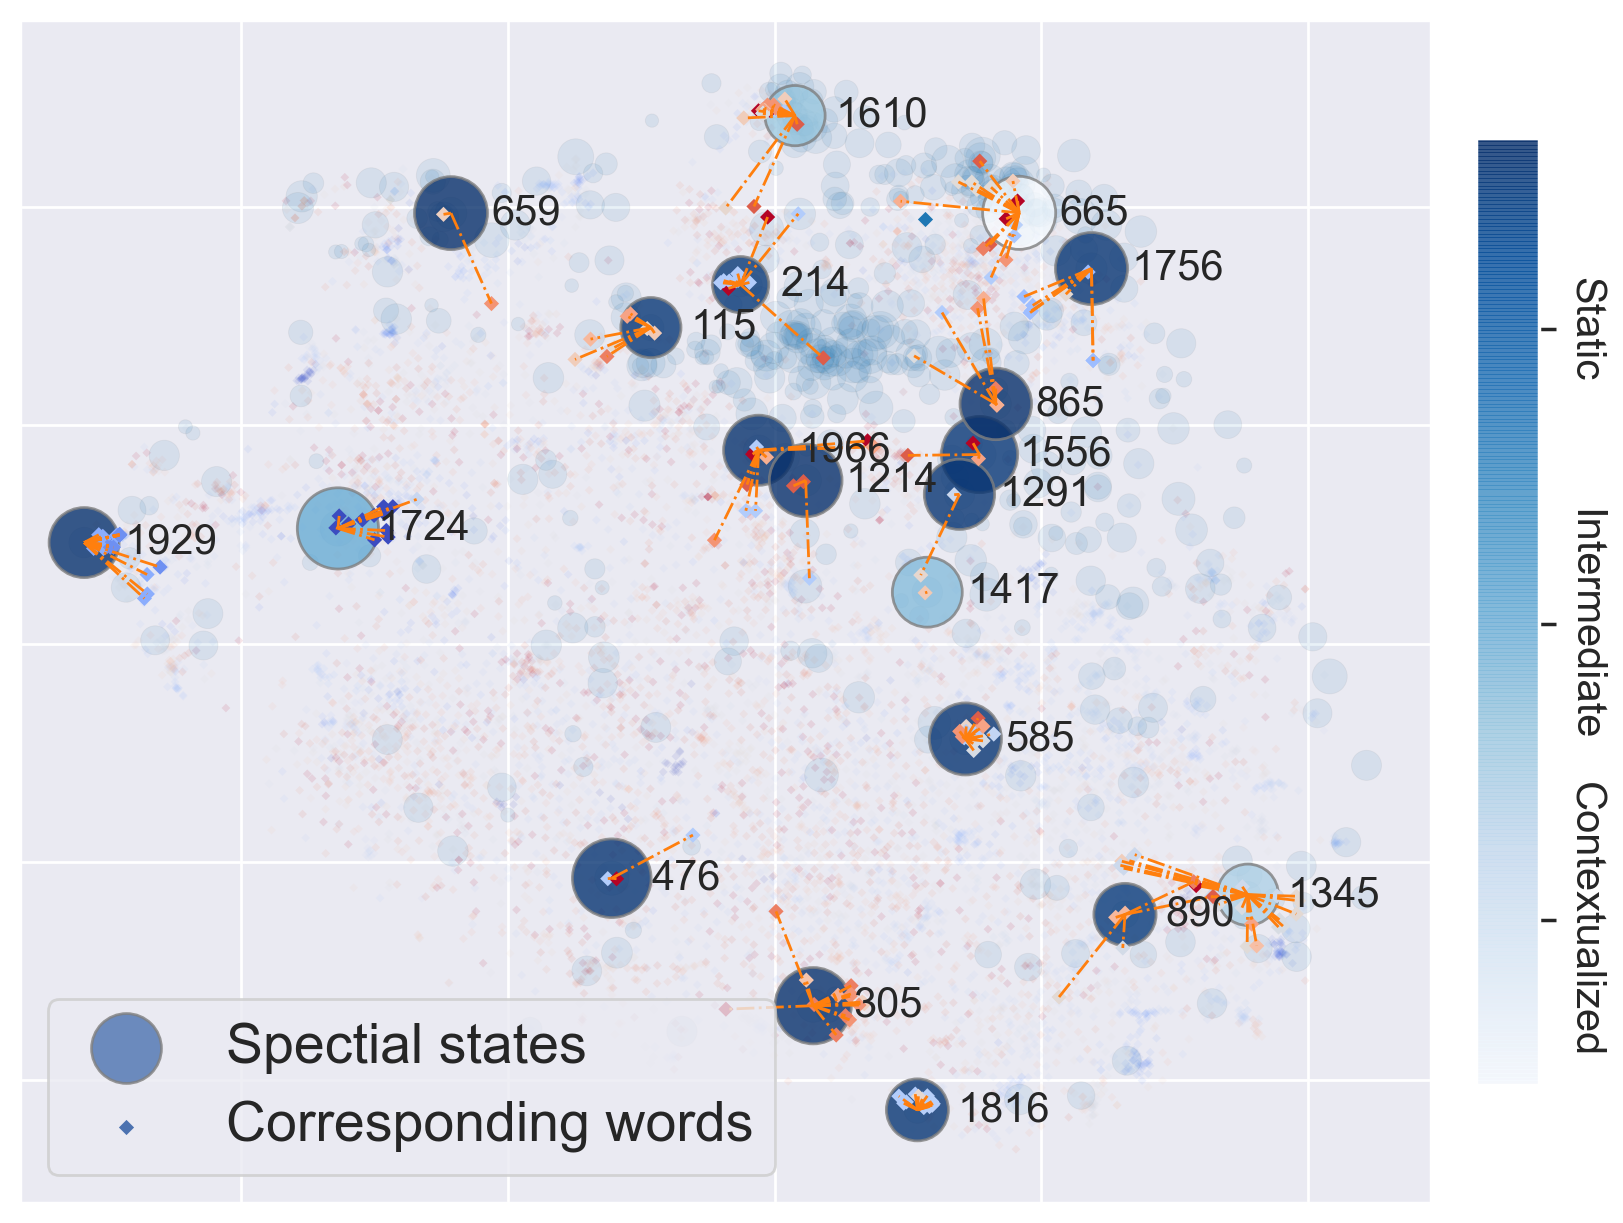

In [103]:
state_word_list = build_state_word_list([1417,  476, 1556, 665, 305, 1724, 1345, 115, 1929,
                                        585, 1966, 865, 214, 1610, 1291,  1214,  659, 890, 1816, 1756], 
                                        state_id_origin_to_topk, sim_word_state, id2word, wordid2sentid, word_id_origin_to_non_stop, word_id_non_stop_to_sampled, n_words=30)
for sw in state_word_list:
    print(sw[2])
plot_state_word_w_query(emb_background_perp_10, 
                        state_matrix_transform_perp_10, 
                        state_nonstop_freq_r_, 
                        state_freq_norm_, 
                        word_sample_freq=word_freq_norm_, 
                        word_only=False, 
                        state_size_base=0.8, 
                        word_size_base=5,
                        filter_static=False, 
                        filter_contextualized=False,
                        state_word_list=state_word_list,
                        high_light_query=True,
                        query_states_scale=1.05,
                        filter_query_dist=10,
                        right_colorbar=True
                       )

## Full

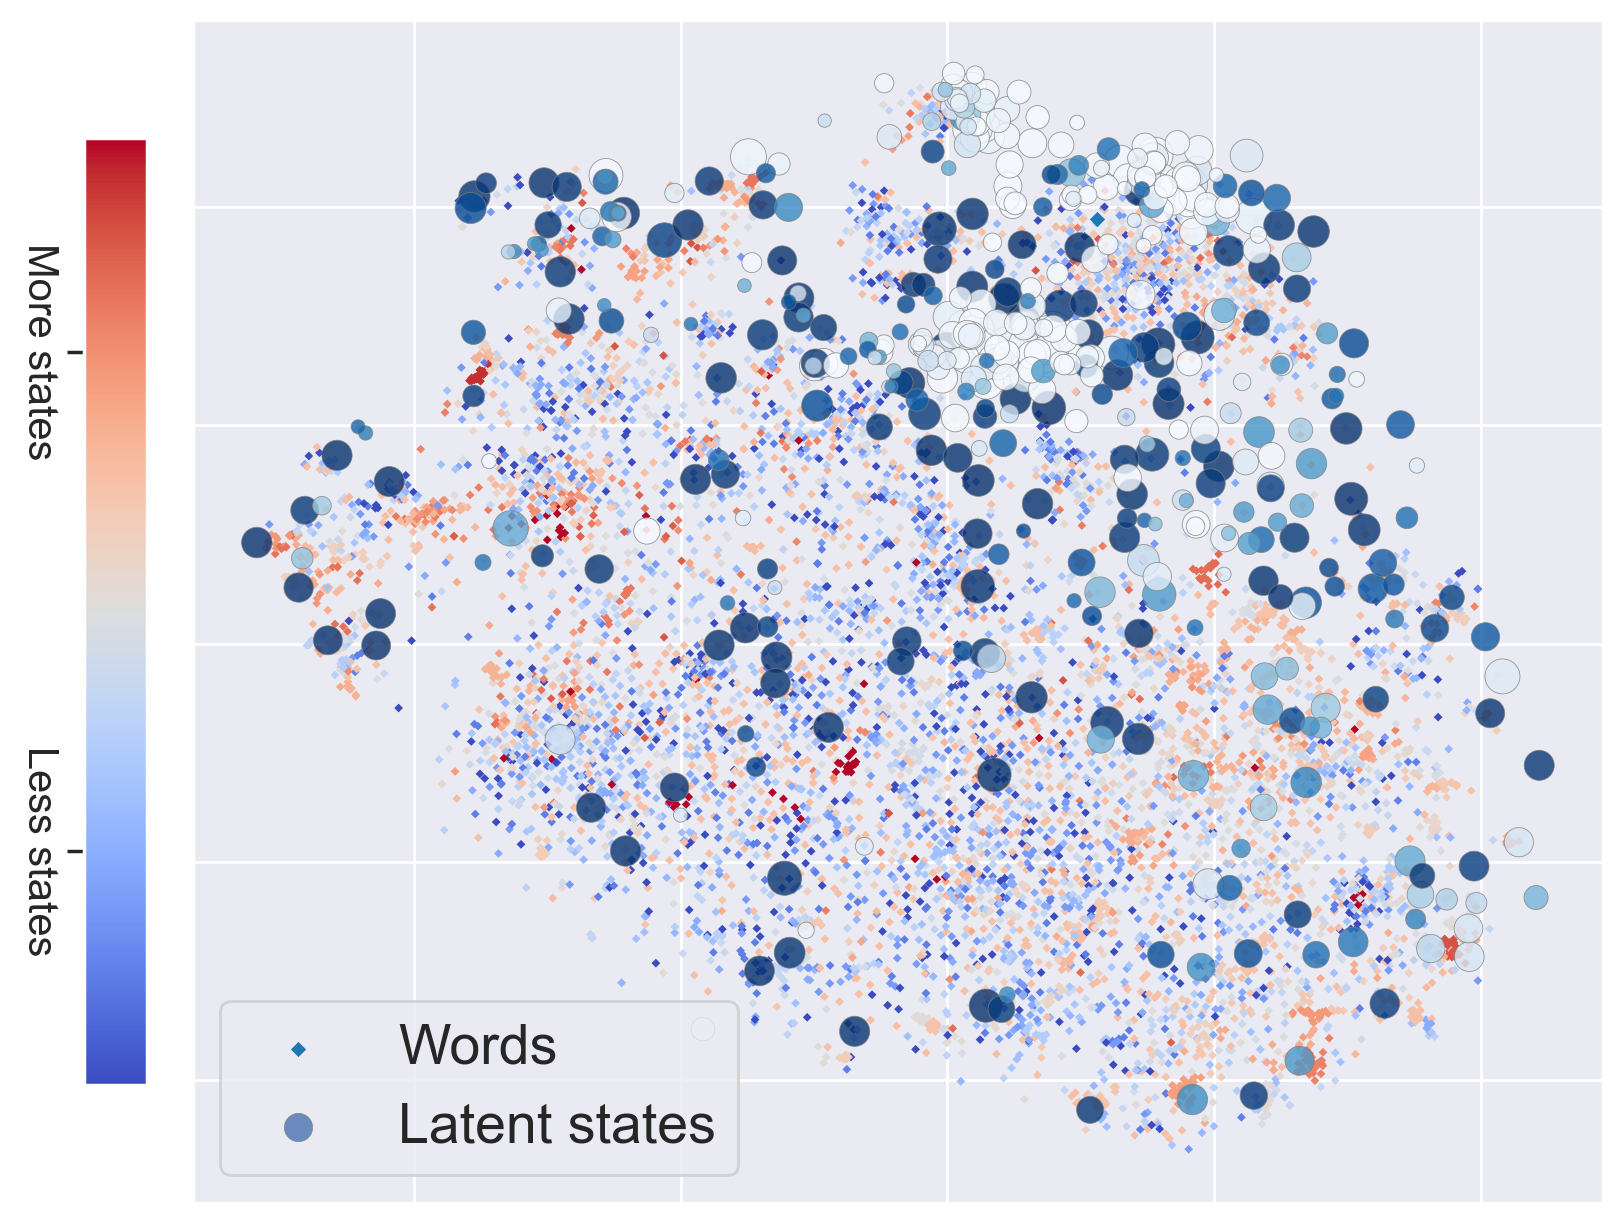

In [116]:
plot_state_word_w_query(emb_background_perp_10, 
                        state_matrix_transform_perp_10, 
                        state_nonstop_freq_r_, 
                        state_freq_norm_, 
                        word_sample_freq=word_freq_norm_, 
                        word_only=False, 
                        state_size_base=0.8, 
                        word_size_base=5,
                        filter_static=False, 
                        filter_contextualized=False,
                        left_colorbar=True
                       )

## query words

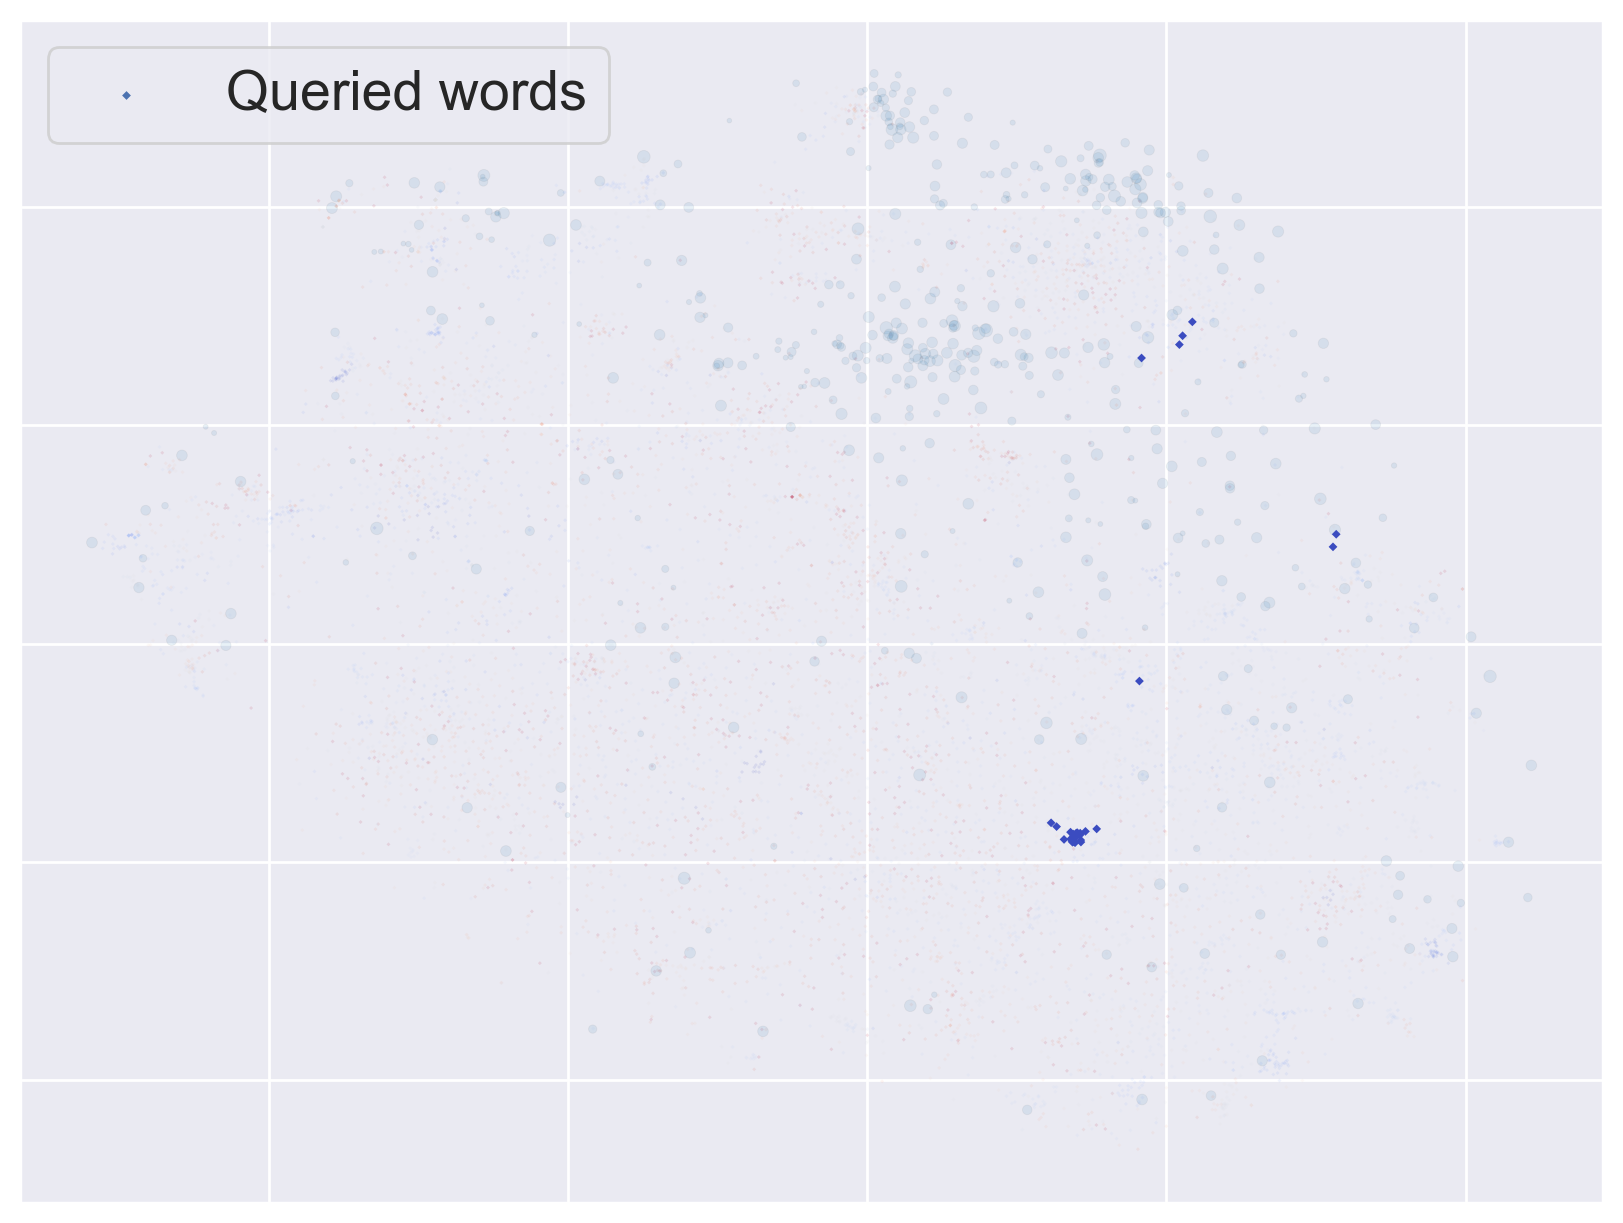

In [84]:
word_list = build_word_list('good', word2idx, word_id_origin_to_non_stop, word_id_non_stop_to_sampled)

plot_state_word_w_query(emb_background_perp_10, 
                        state_matrix_transform_perp_10, 
                        state_nonstop_freq_r_, 
                        state_freq_norm_, 
                        word_sample_freq=word_freq_norm_, 
                        word_only=False, 
                        state_size_base=0.1, 
                        filter_static=False, 
                        filter_contextualized=False,
                        state_word_list=None,
                        high_light_query=True,
                        word_list=word_list
                       )